### Import Necessary Libraries

In [122]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [123]:
df = pd.read_csv("data/train.csv")
print(df)

                   filename  len  num1                     bbox1  num2  \
0          data/train/1.png    2     1        (246, 77, 81, 219)   9.0   
1          data/train/2.png    2     2          (77, 29, 23, 32)   3.0   
2          data/train/3.png    2     2            (17, 5, 8, 15)   5.0   
3          data/train/4.png    2     9          (57, 13, 15, 34)   3.0   
4          data/train/5.png    2     3           (52, 7, 21, 46)   1.0   
...                     ...  ...   ...                       ...   ...   
33397  data/train/33398.png    1     8  (65.0, 18.0, 15.0, 47.0)  -1.0   
33398  data/train/33399.png    1     8  (81.0, 18.0, 28.0, 53.0)  -1.0   
33399  data/train/33400.png    2     9           (36, 3, 25, 45)   5.0   
33400  data/train/33401.png    2     2           (34, 6, 25, 40)   2.0   
33401  data/train/33402.png    3     1           (35, 10, 7, 25)   6.0   

                    bbox2  num3            bbox3  num4 bbox4  num5 bbox5  \
0      (323, 81, 96, 219)  -1.0    

### Split Training Data into Training and Validation Sets

In [124]:
df = pd.read_csv('data/train.csv')
#validation set size = 20%
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the new datasets
train_df.to_csv('data/train_split.csv', index=False)
val_df.to_csv('data/val_split.csv', index=False)

### Define a Custom Dataset Class
This class loads images and corresponding labels, preprocesses them, and returns them in a PyTorch-compatible format.

In [125]:
class HouseNumberDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filename']
        
        # Ensure the file path is correct and exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        
        # Load the image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Unable to load image: {img_path}")
        
        # Preprocess the image
        image = cv2.resize(image, (32, 32))  # Resize to 32x32
        image = image.transpose((2, 0, 1)) / 255.0  # Normalize
        image = torch.tensor(image, dtype=torch.float32)
        
        # Process labels (replace -1 with 10 as placeholder class index)
        labels = row[[f'num{i}' for i in range(1, 6)]].fillna(-1).values
        labels = np.where(labels == -1, 10, labels)  # Replace -1 with placeholder class 10
        labels = torch.tensor(labels, dtype=torch.long)
        return image, labels

### Load Datasets

In [126]:
train_dataset = HouseNumberDataset(csv_file='data/train_split.csv', image_dir='data/train')
val_dataset = HouseNumberDataset(csv_file='data/val_split.csv', image_dir='data/train')
test_dataset = HouseNumberDataset(csv_file='data/test.csv', image_dir='data/test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define the CNN Model

In [127]:
class CNNModel(nn.Module):
    def __init__(self, num_digits=5, num_classes=11):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),  # Adjust input size based on pooling
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),
            nn.Linear(128, num_digits * num_classes)
        )
    
    def forward(self, x):
        x = self.conv(x)  # Pass through convolutional layers
        x = self.fc(x)  # Pass through fully connected layers
        return x.view(x.size(0), -1, 11)  # Reshape output for multi-digit prediction

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

In [129]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Training Loop with Validation

In [130]:
train_losses = []
val_losses = []

def train_model_with_validation(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training Loop
        model.train()
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = 0
            for i in range(labels.size(1)):
                loss += criterion(outputs[:, i, :], labels[:, i])
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation Loop
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = 0
                for i in range(labels.size(1)):
                    loss += criterion(outputs[:, i, :], labels[:, i])
                total_val_loss += loss.item()

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}")

train_model_with_validation(model, train_loader, val_loader, optimizer, criterion, epochs=20)

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [12:19<00:00,  1.77s/it]


Epoch 1/20, Train Loss: 2588.8197, Validation Loss: 604.7573


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.84it/s]


Epoch 2/20, Train Loss: 2415.6837, Validation Loss: 589.8962


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:54<00:00,  7.72it/s]


Epoch 3/20, Train Loss: 2359.3355, Validation Loss: 573.8612


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.75it/s]


Epoch 4/20, Train Loss: 2302.0079, Validation Loss: 558.3259


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.88it/s]


Epoch 5/20, Train Loss: 2221.2638, Validation Loss: 530.8732


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.85it/s]


Epoch 6/20, Train Loss: 2129.8525, Validation Loss: 498.5693


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.85it/s]


Epoch 7/20, Train Loss: 2038.9820, Validation Loss: 473.9836


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:54<00:00,  7.68it/s]


Epoch 8/20, Train Loss: 1966.8933, Validation Loss: 459.8100


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.86it/s]


Epoch 9/20, Train Loss: 1912.0640, Validation Loss: 448.0065


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.87it/s]


Epoch 10/20, Train Loss: 1875.6223, Validation Loss: 432.7838


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:52<00:00,  7.90it/s]


Epoch 11/20, Train Loss: 1838.3944, Validation Loss: 423.8411


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.84it/s]


Epoch 12/20, Train Loss: 1810.5555, Validation Loss: 418.1418


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:52<00:00,  7.93it/s]


Epoch 13/20, Train Loss: 1788.0985, Validation Loss: 414.5010


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:54<00:00,  7.63it/s]


Epoch 14/20, Train Loss: 1763.7547, Validation Loss: 407.0339


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:54<00:00,  7.65it/s]


Epoch 15/20, Train Loss: 1730.8212, Validation Loss: 408.2081


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.84it/s]


Epoch 16/20, Train Loss: 1712.3118, Validation Loss: 399.0813


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:55<00:00,  7.53it/s]


Epoch 17/20, Train Loss: 1690.5499, Validation Loss: 395.7483


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:56<00:00,  7.41it/s]


Epoch 18/20, Train Loss: 1677.6396, Validation Loss: 392.6680


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:55<00:00,  7.59it/s]


Epoch 19/20, Train Loss: 1659.4956, Validation Loss: 392.6110


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [00:53<00:00,  7.84it/s]


Epoch 20/20, Train Loss: 1642.7339, Validation Loss: 389.9793


In [133]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = 0
            for i in range(labels.size(1)):
                loss += criterion(outputs[:, i, :], labels[:, i])
                correct += (outputs[:, i, :].argmax(dim=1) == labels[:, i]).sum().item()
            
            total_loss += loss.item()
    
    print(f"Test Loss: {total_loss:.4f}, Accuracy: {correct / (len(test_loader.dataset) * 5):.4f}")

evaluate_model(model, test_loader, criterion)


Test Loss: 959.9969, Accuracy: 0.7236


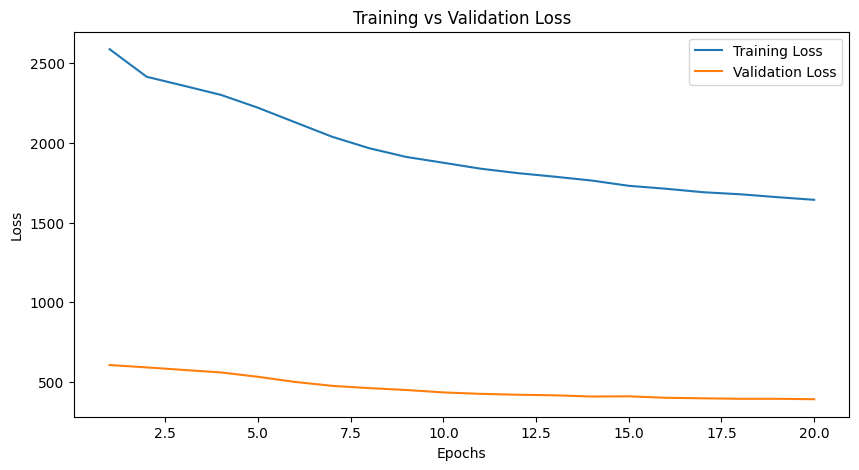

In [134]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()